# ResNet + Deep watershed transform (DWT)

## import, seed, config

In [1]:
!pip install -q ../input/pytorch-segmentation-models-lib/pretrainedmodels-0.7.4/pretrainedmodels-0.7.4
!pip install -q ../input/pytorch-segmentation-models-lib/efficientnet_pytorch-0.6.3/efficientnet_pytorch-0.6.3
!pip install -q ../input/pytorch-segmentation-models-lib/timm-0.4.12-py3-none-any.whl
!pip install -q ../input/pytorch-segmentation-models-lib/segmentation_models_pytorch-0.2.0-py3-none-any.whl

  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.


In [2]:
from tqdm import tqdm_notebook as tqdm
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import CosineAnnealingLR
from sklearn.model_selection import StratifiedKFold
from skimage.segmentation import watershed
from skimage.measure import label
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn.functional as F
import torch
import segmentation_models_pytorch as smp
import pandas as pd
import numpy as np
import cv2
from albumentations.pytorch import ToTensorV2
import albumentations as A
import random
import pickle
import os

def fix_all_seeds(seed):
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


fix_all_seeds(2021)


class config:
    SAMPLE_SUBMISSION = '../input/sartorius-cell-instance-segmentation/sample_submission.csv'
    TRAIN_CSV = "../input/sartorius-cell-instance-segmentation/train.csv"
    TRAIN_PATH = "../input/sartorius-cell-instance-segmentation/train"
    TEST_PATH = "../input/sartorius-cell-instance-segmentation/test"
    MODEL_PATH = "models"
    MASK_PATH = "../input/dwtmasks"
    RESNET_MEAN = (0.485, 0.456, 0.406)
    RESNET_STD = (0.229, 0.224, 0.225)
    IMAGE_RESIZE = (512, 704)
    LR = 5e-4
    min_LR = 5e-5
    model_name = 'resnet101'
    device = 'cuda'
    BS = 8
    num_workers = 2
    N_EPOCH = 50
    N_FOLD = 5
    mask_len = 6
    
os.makedirs(config.MODEL_PATH, exist_ok=True)

In [3]:
df_train = pd.read_csv(config.TRAIN_CSV).groupby('id').first().reset_index()

## check mask dataset

In [4]:
image_id = df_train.iloc[0].id
with open(f'{config.MASK_PATH}/{image_id}.pickle', 'rb') as f:
    masks = pickle.load(f)

len(masks)

7

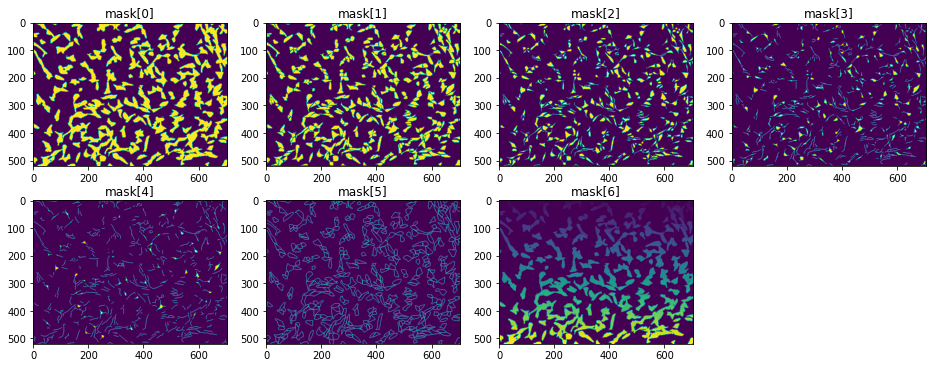

In [5]:
fig = plt.figure(figsize=(16, 6))
for i in range(7):
    fig.add_subplot(2, 4, i + 1)
    plt.gca().title.set_text(f'mask[{i}]')
    plt.imshow(masks[i])
plt.show()

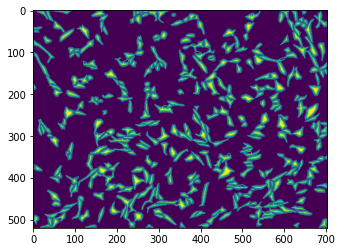

In [6]:
energy = np.mean(np.array(masks[:5]), axis=0)
plt.imshow(energy)

we can get instance segmented mask by watershed algorithm using distance transform.
This is same as masks[6]

In [7]:
def watershed_energy(msk=None,
                     energy=None,
                     threshold=0.5,
                     threshold_energy=0.6,
                     line=False):

    msk_ths = (np.copy(msk) > 255 * threshold) * 1
    energy_ths = (np.copy(energy) > 255 * threshold_energy) * 1

    # Marker labelling
    markers = label(energy_ths)

    labels = watershed(-energy,
                       markers,
                       mask=msk_ths,
                       watershed_line=line)

    return labels


def sigmoid(x):
    return 1 / (1 + np.exp(-x))

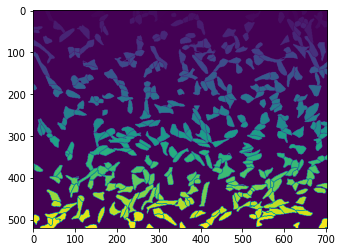

In [8]:
valid_mask = watershed_energy(sigmoid(masks[0]) * 255, sigmoid(energy) * 255, 0.5, 0.7, line=True)
plt.imshow(valid_mask)

## Train

### Dataset and Augmentation

In [9]:
class CellDataset(Dataset):
    def __init__(self, df, transforms):
        self.df = df
        self.base_path = config.TRAIN_PATH
        self.transforms = transforms
        self.image_ids = df.id.unique().tolist()

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        image_path = os.path.join(self.base_path, image_id + ".png")
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        with open(f'{config.MASK_PATH}/{image_id}.pickle', 'rb') as f:
            masks = pickle.load(f)

        augmented = self.transforms(image=image, masks=masks)
        image = augmented['image']
        masks = augmented['masks']
        masks = torch.tensor(np.stack(masks))
        return {'image': image.float(), 'masks': masks.int()}

    def __len__(self):
        return len(self.image_ids)


data_transforms = {
    "train": A.Compose([
        A.Resize(config.IMAGE_RESIZE[0], config.IMAGE_RESIZE[1]),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.ColorJitter(p=0.5),
        A.ChannelShuffle(p=0.25),
        A.ToGray(p=0.25),
        A.Normalize(mean=config.RESNET_MEAN, std=config.RESNET_STD, p=1),
        ToTensorV2()], p=1.0),

    "valid": A.Compose([
        A.Resize(config.IMAGE_RESIZE[0], config.IMAGE_RESIZE[1]),
        A.Normalize(mean=config.RESNET_MEAN, std=config.RESNET_STD, p=1),
        ToTensorV2()], p=1.0)
}

### Utils

In [10]:
def compute_iou(labels, y_pred):

    true_objects = len(np.unique(labels))
    pred_objects = len(np.unique(y_pred))

    intersection = np.histogram2d(
        labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects)
    )[0]

    area_true = np.histogram(labels, bins=true_objects)[0]
    area_pred = np.histogram(y_pred, bins=pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    union = area_true + area_pred - intersection
    intersection = intersection[1:, 1:]  # exclude background
    union = union[1:, 1:]
    union[union == 0] = 1e-9
    iou = intersection / union

    return iou


def precision_at(threshold, iou):

    matches = iou > threshold
    true_positives = np.sum(matches, axis=1) >= 1  # Correct objects
    false_negatives = np.sum(matches, axis=1) == 0  # Missed objects
    false_positives = np.sum(matches, axis=0) == 0  # Extra objects
    tp, fp, fn = (
        np.sum(true_positives),
        np.sum(false_positives),
        np.sum(false_negatives),
    )
    return tp, fp, fn


def iou_map(truths, preds, verbose=0):

    ious = [compute_iou(truth.numpy().astype(int), pred.numpy().astype(int)) for truth, pred in zip(truths, preds)]


    if verbose:
        print("Thresh\tTP\tFP\tFN\tPrec.")

    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        tps, fps, fns = 0, 0, 0
        for iou in ious:
            tp, fp, fn = precision_at(t, iou)
            tps += tp
            fps += fp
            fns += fn

        p = tps / (tps + fps + fns)
        prec.append(p)

        if verbose:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tps, fps, fns, p))

    if verbose:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))

    return np.mean(prec)

### Train and valid loop

In [11]:
def train_loop(model, optimizer, loader, criterion):
    losses, lrs = [], []
    model.train()
    optimizer.zero_grad()
    for d in loader:
        y = d['masks'].to(config.device)
        pred_y = model(d['image'].to(config.device))
        loss = criterion(pred_y, y[:, :-1].float())
        losses.append(loss.item())
        step_lr = np.array([param_group["lr"] for param_group in optimizer.param_groups]).mean()
        lrs.append(step_lr)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    return np.array(losses).mean(), np.array(lrs).mean()


def valid_loop(model, loader, criterion):
    losses, true_masks, pred_masks, pred_energys = [], [], [], []
    model.eval()
    for d in loader:
        with torch.no_grad():
            y = d['masks'].to(config.device)
            pred_y = model(d['image'].to(config.device))
            loss = criterion(pred_y, y[:, :-1].float())
        losses.append(loss.item())
        energy = torch.mean(F.sigmoid(pred_y[:, :(config.mask_len - 1)]), dim=1)
        pred_masks.append(F.sigmoid(pred_y[:, 0].cpu()))
        true_masks.append(y[:, -1].cpu())
        pred_energys.append(energy.cpu())
    pred_masks = torch.cat(pred_masks)
    true_masks = torch.cat(true_masks)
    pred_energys = torch.cat(pred_energys)
    return np.array(losses).mean(), true_masks, pred_masks, pred_energys

### Training

In [12]:
skf = StratifiedKFold(n_splits=config.N_FOLD, shuffle=True)
for fold, (_, valid_idx) in enumerate(skf.split(df_train, df_train.cell_type)):
    df_train.loc[valid_idx, 'fold'] = fold
    
for fold in range(config.N_FOLD):
    print(f"Fold: {fold}")
    train_dset = CellDataset(df_train.query(f"fold!={fold}"), data_transforms['train'])
    valid_dset = CellDataset(df_train.query(f"fold=={fold}"), data_transforms['valid'])

    train_loader = DataLoader(train_dset, batch_size=config.BS,
                              pin_memory=True, shuffle=True, num_workers=config.num_workers,
                              worker_init_fn=lambda x: np.random.seed(torch.initial_seed() // 2 ** 32 + x))
    valid_loader = DataLoader(valid_dset, batch_size=config.BS * 2,
                              pin_memory=True, shuffle=False, drop_last=False, num_workers=config.num_workers)

    model = smp.Unet(config.model_name, encoder_weights="imagenet", activation=None, classes=config.mask_len)
    model = model.to(config.device)

    optimizer = optim.Adam(model.parameters(), lr=config.LR)
    criterion = smp.losses.JaccardLoss(mode='multilabel')
    scheduler = CosineAnnealingLR(optimizer, T_max=config.N_EPOCH, eta_min=config.min_LR)

    valid_best_score = 0.
    for epoch in tqdm(range(config.N_EPOCH)):
        train_loss, lrs = train_loop(model, optimizer, train_loader, criterion)
        valid_loss, valid_mask, valid_pred_mask, valid_pred_energy = valid_loop(model, valid_loader, criterion)

        preds_wt = torch.stack([torch.tensor(watershed_energy(pred.numpy() * 255, energy.numpy() * 255, 0.5, 0.7)) for pred, energy in zip(valid_pred_mask, valid_pred_energy)])
        valid_score_energy = iou_map(valid_mask, preds_wt)
        if valid_score_energy > valid_best_score:
            print(f"epoch: {epoch}, train_loss: {train_loss:.3f}, valid_loss: {valid_loss:.3f}, meanIoU: {valid_score_energy:.3f}")
            valid_best_score = valid_score_energy
            torch.save(model.state_dict(), f'{config.MODEL_PATH}/{config.model_name}_{fold}.pth')
        scheduler.step()
    break

Fold: 0


Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth


  0%|          | 0.00/170M [00:00<?, ?B/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/50 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


epoch: 0, train_loss: 0.921, valid_loss: 0.881, meanIoU: 0.004
epoch: 1, train_loss: 0.888, valid_loss: 0.827, meanIoU: 0.009
epoch: 2, train_loss: 0.830, valid_loss: 0.777, meanIoU: 0.058
epoch: 3, train_loss: 0.755, valid_loss: 0.677, meanIoU: 0.079
epoch: 5, train_loss: 0.680, valid_loss: 0.634, meanIoU: 0.099
epoch: 6, train_loss: 0.665, valid_loss: 0.656, meanIoU: 0.110
epoch: 7, train_loss: 0.653, valid_loss: 0.661, meanIoU: 0.112
epoch: 8, train_loss: 0.646, valid_loss: 0.618, meanIoU: 0.116
epoch: 9, train_loss: 0.628, valid_loss: 0.601, meanIoU: 0.119
epoch: 10, train_loss: 0.627, valid_loss: 0.610, meanIoU: 0.124
epoch: 11, train_loss: 0.617, valid_loss: 0.612, meanIoU: 0.131
epoch: 12, train_loss: 0.619, valid_loss: 0.605, meanIoU: 0.148
epoch: 14, train_loss: 0.613, valid_loss: 0.589, meanIoU: 0.152
epoch: 15, train_loss: 0.605, valid_loss: 0.585, meanIoU: 0.157
epoch: 22, train_loss: 0.595, valid_loss: 0.597, meanIoU: 0.163
epoch: 28, train_loss: 0.578, valid_loss: 0.577, 